#Fashion Trend Analysis Using AI
This project finetunes state-of-the-art image-to-text models to detect the cloths and fashion items in pictures and then analyze fashion trends using prompt engineering. It combines image recognition and natural language processing to provide valuable market insights.

##Install necessary libraries

In [3]:
pip install datasets transformers spacy nltk textblob pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

We used the fashion_text_to_image dataset from Hugging Face.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import io
from torch.utils.data._utils.collate import default_collate

In [2]:
from datasets import load_dataset

# Load the fashion_text_to_image dataset
dataset = load_dataset('duyngtr16061999/fashion_text_to_image')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/60139 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7519 [00:00<?, ? examples/s]

In [ ]:
# Display the first few examples in the dataset
print(dataset['train'][0])


{'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\x00\x01\x00\x08\x02\x00\x00\x00\xd3\x10?1\x00\x00p\xf7IDATx\x9c\xed\xfdi\xb0d\xd9q\x1e\x08~\xee\xe7\xdc\x1b\xeb\xdb_n\x95\xb5\xa3\xaa\xb0\x13"\x04\x10\x05Pd\xb3)J\x14Iu\xf7\xc8$\xb2[\xad\xb11\xd9\x98\xf5Hm\xb2\x9e\x1eM\xcf\xfc\x1a\x9b\x1f3fcc=\xd66\xa3_-\xaa[\x1b[=\xc3m\xa8!\x01\x92\xdd\\\xc0E \x05\x80 \x00\x82X\n\x05\x14P@Uf\xe5\x9e/\xdf\x16\xcb\xbd\xe7\xb8\xcf\x0f?\xe7\xde\x1b/\xb3\xc0E\x99\x95U/\xc2\x01$\xe2E\xdc\xb8\xf7F\x84\xfb9\xee\x9f\x7f\xeeN\xaa\x8a\x95\xbcQ2\x9fM_\xfd\xc6\x8b\xbf\xfb\xeb\xbfv\xe9k_\xfc\xc0\x0f\xfc\xd5g\xde\xf3\xdd_\xff\xd2\xe7\xaf\xbe\xf2\xb2g~\xc7{\xdf\xf7\xec\xfb>\xb8u\xe6,\xb3{\xd8\xb7\xb9DB+\x03x\x03DU\xabj\xbe\x7f\xe3\xfa\xa7~\xebW\x7f\xe3\x97~\xfe\xd2\xd5\xeb\x9b\x83b\xe3\xec\xc5\xfdY\xb8\xf4\xea\xab\x1a\xe6}\xcf\x17w7v/>\xf5\x81\x0f\x7f\xdf\xf3\x7f\xe5G/<\xfe\xf4\xc3\xbe\xe5e\x91\x95\x01<p\xa9\xab\xf9\xe7\x7f\xffw_\xf8\xec\xa7\xbe\xf9\xc2\x1f]~\xe5\xdb\xc7\xd3)\x11\x08z4\x0b\xd7\x0fg \

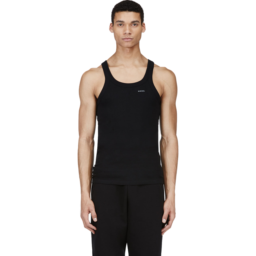

a crewneck tank top in black.


In [3]:
from PIL import Image
import io
from IPython.display import display

# Function to decode and display image inline
def decode_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    display(image)

# Display an example in the dataset
first_product = dataset['train'][6]
image_bytes = first_product['image']
product_text = first_product['text']
decode_image(image_bytes)
print(product_text)


##Prepare data and Initialize the Pre-trained CLIP Model and Processor

In [4]:
class FashionDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(io.BytesIO(item['image']))
        text = item['text']
        # Ensure padding=True
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        # Flatten inputs to remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs



# Load dataset
train_dataset = dataset['train']#[0:100]###########################################################

# Initialize the processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

# Prepare the dataset
train_dataset = FashionDataset(train_dataset, processor)
train_loader = DataLoader(train_dataset, batch_size=90, shuffle=False)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

## Fine-tune CLIP image-to-text model to generate accurate descriptions of clothing and fashion items in a picture

In [7]:

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# Training loop
num_epochs = 1
model.train()

for epoch in range(num_epochs):
  running_loss = 0.0
  for batch in train_loader:
        optimizer.zero_grad()

        inputs = {key: value.squeeze().to(device) for key, value in batch.items()}

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        ground_truth = torch.arange(len(logits_per_image)).to(device)

        loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress every 10 batches
        #if i % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 2.223667621612549
Epoch 1, Loss: 6.831541061401367
Epoch 1, Loss: 3.927089214324951
Epoch 1, Loss: 3.861639976501465
Epoch 1, Loss: 3.442234992980957


KeyboardInterrupt: 

In [8]:
# After fine-tuning
tuned_model_path = "fine_tuned_clip_model.pth"
torch.save(model.state_dict(), tuned_model_path)
print(f"Fine-tuned model saved to {tuned_model_path}")


Fine-tuned model saved to fine_tuned_clip_model.pth


In [9]:
# Loading the fine-tuned model
fine_tuned_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
fine_tuned_model.load_state_dict(torch.load(tuned_model_path))
fine_tuned_model.to(device)
print("Fine-tuned model loaded.")

Fine-tuned model loaded.


##Extract all unique text descriptions and tokenize them

In [10]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Extract all unique text descriptions
text_descriptions = list(set([item['text'] for item in dataset['train']]))

# Tokenize the text descriptions
text_inputs = processor(text=text_descriptions, return_tensors="pt", padding=True, truncation=True)

# Move text inputs to the appropriate device
text_inputs = {key: value.to(device) for key, value in text_inputs.items()}




In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel

# Create a dataset and dataloader for text descriptions
text_dataset = TextDataset(text_descriptions, processor)
text_loader = DataLoader(text_dataset, batch_size=16, shuffle=False)

# Function to compute text embeddings in batches
def compute_text_embeddings(model, text_loader):
    model.eval()
    text_features = []

    with torch.no_grad():
        for batch in text_loader:
            batch = {key: value.to(device) for key, value in batch.items()}
            text_embeds = model.get_text_features(**batch)
            text_features.append(text_embeds)

    # Concatenate all the batches
    text_features = torch.cat(text_features, dim=0)
    return text_features

# Compute text embeddings in batches
text_features = compute_text_embeddings(model, text_loader)

In [ ]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

## Compute text embeddings

In [11]:


# Create a custom dataset class for text descriptions
class TextDataset(Dataset):
    def __init__(self, text_descriptions, processor):
        self.text_descriptions = text_descriptions
        self.processor = processor

    def __len__(self):
        return len(self.text_descriptions)

    def __getitem__(self, idx):
        text = self.text_descriptions[idx]
        inputs = self.processor(text=[text], return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        inputs = {key: value.squeeze(0) for key, value in inputs.items()}
        return inputs

# Extract all unique text descriptions
text_descriptions = list(set([item['text'] for item in dataset['train']]))

# Create a dataset and dataloader for text descriptions
text_dataset = TextDataset(text_descriptions, processor)
text_loader = DataLoader(text_dataset, batch_size=16, shuffle=False)

# Function to compute text embeddings in batches
def compute_text_embeddings(model, text_loader):
    model.eval()
    text_features = []

    with torch.no_grad():
        for batch in text_loader:
            batch = {key: value.to(device) for key, value in batch.items()}
            text_embeds = model.get_text_features(**batch)
            text_features.append(text_embeds)

    # Concatenate all the batches
    text_features = torch.cat(text_features, dim=0)
    return text_features

# Compute text embeddings in batches
text_features = compute_text_embeddings(model, text_loader)



##Generate descriotion of cloths

In [12]:

# Function to generate a caption for an image
def generate_caption(image_bytes, model, processor, text_features, text_descriptions):
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    image_inputs = processor(images=image, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        image_features = model.get_image_features(**image_inputs)

    # Compute cosine similarity between image and text features
    similarities = torch.nn.functional.cosine_similarity(image_features, text_features)
    best_match_idx = similarities.argmax().item()

    # Retrieve the best matching text description
    caption = text_descriptions[best_match_idx]

    return caption





In [13]:
# Example usage
product = dataset['validation'][5]
image_bytes = product['image']

In [14]:

generated_caption = generate_caption(image_bytes, model, processor, text_features, text_descriptions)
print("Generated Caption:", generated_caption)

Generated Caption: a long sleeve cotton herringbone shirt featuring check pattern in black and red.


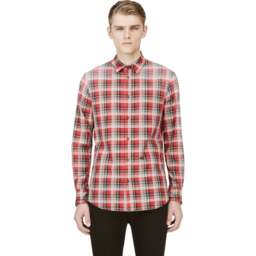

a person with long sleeve shirt in red, white, and black plaid.


In [15]:
# Display an example in the dataset

val_image_bytes = product['image']
val_text = product['text']
decode_image(val_image_bytes)
print(val_text)


In [16]:
# Generate captions for the first 10 validation items
captions = []
for i in range(10):
    product = dataset['validation'][i]  # Access each validation item individually
    image_data = product['image']  # Assuming 'image' contains the raw image data
    image_bytes = bytes(image_data)  # Convert to bytes-like object if necessary
    caption = generate_caption(image_bytes, model, processor, text_features, text_descriptions)
    captions.append(f"{i+1}. {caption}")


In [18]:
# Create the prompt with generated captions
prompt = f"""
Given the following descriptions of fashion items, identify the current fashion trends:
{', '.join(captions)}

Based on these items, what are the prevailing fashion trends?
"""


In [19]:
# Initialize the model for text generation (replace with appropriate model)
trend_model = pipeline("text-generation", model="gpt2")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
# Generate the response
response = trend_model(prompt, max_length=250, num_return_sequences=1)
print("Fashion Trends:", response[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Fashion Trends: 
Given the following descriptions of fashion items, identify the current fashion trends:
1. a classic leather biker jacket in navy blue., 2. an image of opaque nylon tights in white., 3. a classic leather biker jacket in navy blue., 4. a opaque nylon tights in black., 5. a opaque nylon tights in black., 6. a long sleeve cotton herringbone shirt featuring check pattern in black and red., 7. a jersey muscle tank in black., 8. a long sleeve long blazer in black., 9. a picture of long sleeve herringbone cotton jacket in grey., 10. an image of fitted virgin wool officer jacket in black.

Based on these items, what are the prevailing fashion trends?

One is black, two is white.

Which is the dominant fashion trend?

If you are looking for a sporty look, look for one of the three outfits: the blue leather or a tan button-up, and the navy blue jacket.

The blue leather is the new blue with an understated side and the navy blue jacket is the new white with an understated side. T

## Next Steps for Fashion Trend Analysis Using AI

### 1. Exposure to Diverse Images
- **Social Media**: Extract images and descriptions from social media platforms like Instagram, Pinterest, or fashion blogs to diversify the dataset.
- **Clothing Retail Websites**: Scrape product images and descriptions from online retail stores like Zara, H&M, or ASOS to get a wide variety of fashion items.

### 2. Improve Data Collection
- **Automate Scraping**: Write scripts to automate the collection of images and descriptions from these sources.
- **APIs**: Use available APIs (like the Instagram API) to gather data more efficiently.

### 3. Enhance Prompts
- **Specific Trends**: Create prompts that ask for specific trends, such as seasonal trends, color trends, or trends in specific types of clothing (e.g., jackets, jeans).
- **Comparative Prompts**: Compare trends between different time periods or regions.

### 4. Refine Model Training
- **Fine-Tune with More Data**: Continue fine-tuning the model with the expanded and more diverse dataset.
- **Use Different Models**: Experiment with other models on Hugging Face that might better suit your needs, such as BERT, RoBERTa, or even other versions of GPT.

### 5. Model Evaluation and Validation
- **Quantitative Evaluation**: Implement metrics to evaluate the quality of generated text (e.g., BLEU score, ROUGE score).
- **Qualitative Evaluation**: Conduct human evaluation to assess the relevance and accuracy of the generated trends.

### 6. Visualization
- **Trend Analysis**: Visualize the identified trends using text to image algorithms